"""
Health Insurance Prediction System - Fixed and Production-Ready
Combined Eligibility Classification & Cost Prediction with Hybrid Models
"""

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                               GradientBoostingRegressor, StackingClassifier, 
                               StackingRegressor, VotingClassifier)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (classification_report, confusion_matrix, 
                              accuracy_score, mean_squared_error, 
                              r2_score, mean_absolute_error)
import joblib
import warnings
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Cell 2: Generate Dataset
np.random.seed(42)
n_samples = 1000

print("Generating Sample Dataset...")

data = {
    'age': np.random.randint(18, 70, n_samples),
    'gender': np.random.choice(['Male', 'Female'], n_samples),
    'bmi': np.round(np.random.normal(26, 5, n_samples), 1),
    'children': np.random.randint(0, 5, n_samples),
    'smoker': np.random.choice(['Yes', 'No'], n_samples, p=[0.2, 0.8]),
    'region': np.random.choice(['Northeast', 'Northwest', 'Southeast', 'Southwest'], n_samples),
    'pre_existing_conditions': np.random.choice(
        ['None', 'Diabetes', 'Hypertension', 'Heart Disease', 'Asthma'], 
        n_samples, p=[0.5, 0.15, 0.15, 0.1, 0.1]
    ),
    'employment_status': np.random.choice(
        ['Employed', 'Self-Employed', 'Unemployed', 'Retired'], 
        n_samples, p=[0.6, 0.2, 0.1, 0.1]
    ),
    'annual_income': np.random.randint(20000, 150000, n_samples),
    'previous_claims': np.random.randint(0, 10, n_samples)
}

df = pd.DataFrame(data)
print(df.head())

Generating Sample Dataset...
   age  gender   bmi  children smoker     region pre_existing_conditions  \
0   56    Male  25.9         2     No  Northwest                    None   
1   69    Male  31.9         0     No  Southeast                  Asthma   
2   46    Male  38.6         0     No  Northeast            Hypertension   
3   32  Female  23.3         4     No  Southeast                Diabetes   
4   60    Male  23.6         1    Yes  Northwest                    None   

  employment_status  annual_income  previous_claims  
0          Employed         126263                3  
1          Employed         130284                3  
2     Self-Employed         137399                9  
3          Employed         124885                8  
4          Employed         142393                2  


In [4]:
# Cell 3: Create Target Variables
def determine_eligibility(row):
    score = 0
    if row['age'] < 60: score += 2
    if row['smoker'] == 'No': score += 3
    if row['pre_existing_conditions'] == 'None': score += 3
    if row['bmi'] < 30: score += 1
    if row['annual_income'] > 30000: score += 1
    return 'Eligible' if score >= 6 else 'Not Eligible'

def calculate_cost(row):
    base_cost = 5000
    cost = base_cost
    cost += (row['age'] - 18) * 250
    cost += row['bmi'] * 100
    cost += row['children'] * 1500
    if row['smoker'] == 'Yes': cost *= 1.6
    if row['pre_existing_conditions'] != 'None': cost *= 1.3
    cost += row['previous_claims'] * 800
    cost += np.random.normal(0, 2000)
    return max(1000, round(cost, 2))

df['eligibility'] = df.apply(determine_eligibility, axis=1)
df['eligible_binary'] = (df['eligibility'] == 'Eligible').astype(int)
df['insurance_cost'] = df.apply(calculate_cost, axis=1)

print(f"Dataset created: {df.shape}")
print(f"\nEligibility Distribution:\n{df['eligibility'].value_counts()}")
print(f"\nCost Statistics:\n{df['insurance_cost'].describe()}")

Dataset created: (1000, 13)

Eligibility Distribution:
eligibility
Eligible        796
Not Eligible    204
Name: count, dtype: int64

Cost Statistics:
count     1000.00000
mean     25381.22984
std       8744.91384
min       5186.25000
25%      19348.16500
50%      24205.31500
75%      29695.31500
max      61647.13000
Name: insurance_cost, dtype: float64


In [5]:
# Cell 4: Data Preprocessing
le_dict = {}
categorical_cols = ['gender', 'smoker', 'region', 'pre_existing_conditions', 'employment_status']

df_processed = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    le_dict[col] = le

feature_cols = ['age', 'bmi', 'children', 'annual_income', 'previous_claims'] + \
               [col + '_encoded' for col in categorical_cols]

X = df_processed[feature_cols]
y_eligibility = df_processed['eligible_binary']
y_cost = df_processed['insurance_cost']

# Train-test split
X_train, X_test, y_elig_train, y_elig_test, y_cost_train, y_cost_test = \
    train_test_split(X, y_eligibility, y_cost, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Training set: (800, 10)
Test set: (200, 10)


In [ ]:

# Cell 5: Eligibility Models - Stacking Ensemble
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

eligibility_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

eligibility_model.fit(X_train, y_elig_train)
y_elig_pred = eligibility_model.predict(X_test)
y_elig_proba = eligibility_model.predict_proba(X_test)[:, 1]

elig_accuracy = accuracy_score(y_elig_test, y_elig_pred)
print(f"\n=== ELIGIBILITY MODEL ===")
print(f"Stacking Classifier Accuracy: {elig_accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_elig_test, y_elig_pred)}")


=== ELIGIBILITY MODEL ===
Stacking Classifier Accuracy: 0.9900

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        49
           1       0.99      1.00      0.99       151

    accuracy                           0.99       200
   macro avg       0.99      0.98      0.99       200
weighted avg       0.99      0.99      0.99       200



In [ ]:
# Cell 6: Cost Models - Hybrid Approach with Eligibility Feature
# Add eligibility probability as a feature
X_train_augmented = X_train.copy()
X_test_augmented = X_test.copy()

# Generate eligibility probabilities for training set using cross-validation to avoid leakage
train_elig_proba = np.zeros(len(X_train))
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(X_train):
    temp_model = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=LogisticRegression(random_state=42)
    )
    temp_model.fit(X_train.iloc[train_idx], y_elig_train.iloc[train_idx])
    train_elig_proba[val_idx] = temp_model.predict_proba(X_train.iloc[val_idx])[:, 1]

X_train_augmented['eligibility_score'] = train_elig_proba
X_test_augmented['eligibility_score'] = eligibility_model.predict_proba(X_test)[:, 1]

# Stacking Regressor for Cost Prediction
base_regressors = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

cost_model = StackingRegressor(
    estimators=base_regressors,
    final_estimator=Ridge(),
    cv=5
)

cost_model.fit(X_train_augmented, y_cost_train)
y_cost_pred = cost_model.predict(X_test_augmented)

cost_r2 = r2_score(y_cost_test, y_cost_pred)
cost_rmse = np.sqrt(mean_squared_error(y_cost_test, y_cost_pred))
cost_mae = mean_absolute_error(y_cost_test, y_cost_pred)

print(f"\n=== COST PREDICTION MODEL ===")
print(f"Stacking Regressor R² Score: {cost_r2:.4f}")
print(f"RMSE: ${cost_rmse:,.2f}")
print(f"MAE: ${cost_mae:,.2f}")


=== COST PREDICTION MODEL ===
Stacking Regressor R² Score: 0.9157
RMSE: $2,575.02
MAE: $2,101.33


In [8]:
# Cell 7: Integrated Pipeline Class
class HybridInsurancePredictor:
    """Production-ready hybrid predictor combining eligibility and cost models"""
    
    def __init__(self, eligibility_model, cost_model, label_encoders, feature_cols):
        self.eligibility_model = eligibility_model
        self.cost_model = cost_model
        self.label_encoders = label_encoders
        self.feature_cols = feature_cols
    
    def preprocess_input(self, patient_data):
        """Convert raw patient data to model input format"""
        processed = patient_data.copy()
        
        for col, le in self.label_encoders.items():
            if col in processed.columns:
                processed[col + '_encoded'] = le.transform(processed[col])
        
        return processed[self.feature_cols]
    
    def predict(self, patient_data):
        """Make eligibility and cost predictions"""
        X = self.preprocess_input(patient_data)
        
        # Eligibility prediction
        elig_pred = self.eligibility_model.predict(X)
        elig_proba = self.eligibility_model.predict_proba(X)[:, 1]
        
        # Augment with eligibility score
        X_aug = X.copy()
        X_aug['eligibility_score'] = elig_proba
        
        # Cost prediction
        cost_pred = self.cost_model.predict(X_aug)
        
        results = pd.DataFrame({
            'eligible': elig_pred,
            'eligibility_probability': elig_proba,
            'predicted_cost': cost_pred
        })
        
        return results

In [9]:
# Cell 8: Save Models
hybrid_predictor = HybridInsurancePredictor(
    eligibility_model=eligibility_model,
    cost_model=cost_model,
    label_encoders=le_dict,
    feature_cols=feature_cols
)

joblib.dump(hybrid_predictor, 'hybrid_insurance_predictor.pkl')
joblib.dump(df_processed, 'sample_data.pkl')

print("\n=== MODELS SAVED ===")
print("Saved: hybrid_insurance_predictor.pkl")
print("Saved: sample_data.pkl")


=== MODELS SAVED ===
Saved: hybrid_insurance_predictor.pkl
Saved: sample_data.pkl


In [10]:
# Cell 9: Test Prediction
test_patient = pd.DataFrame({
    'age': [35],
    'gender': ['Male'],
    'bmi': [24.5],
    'children': [2],
    'smoker': ['No'],
    'region': ['Northeast'],
    'pre_existing_conditions': ['None'],
    'employment_status': ['Employed'],
    'annual_income': [75000],
    'previous_claims': [1]
})

print("\n=== SAMPLE PREDICTION ===")
print("Input Patient Data:")
print(test_patient.T)

results = hybrid_predictor.predict(test_patient)
print("\nPrediction Results:")
print(f"Eligible: {'Yes' if results['eligible'].iloc[0] else 'No'}")
print(f"Eligibility Confidence: {results['eligibility_probability'].iloc[0]:.2%}")
print(f"Predicted Annual Cost: ${results['predicted_cost'].iloc[0]:,.2f}")


=== SAMPLE PREDICTION ===
Input Patient Data:
                                 0
age                             35
gender                        Male
bmi                           24.5
children                         2
smoker                          No
region                   Northeast
pre_existing_conditions       None
employment_status         Employed
annual_income                75000
previous_claims                  1

Prediction Results:
Eligible: Yes
Eligibility Confidence: 98.85%
Predicted Annual Cost: $15,698.89


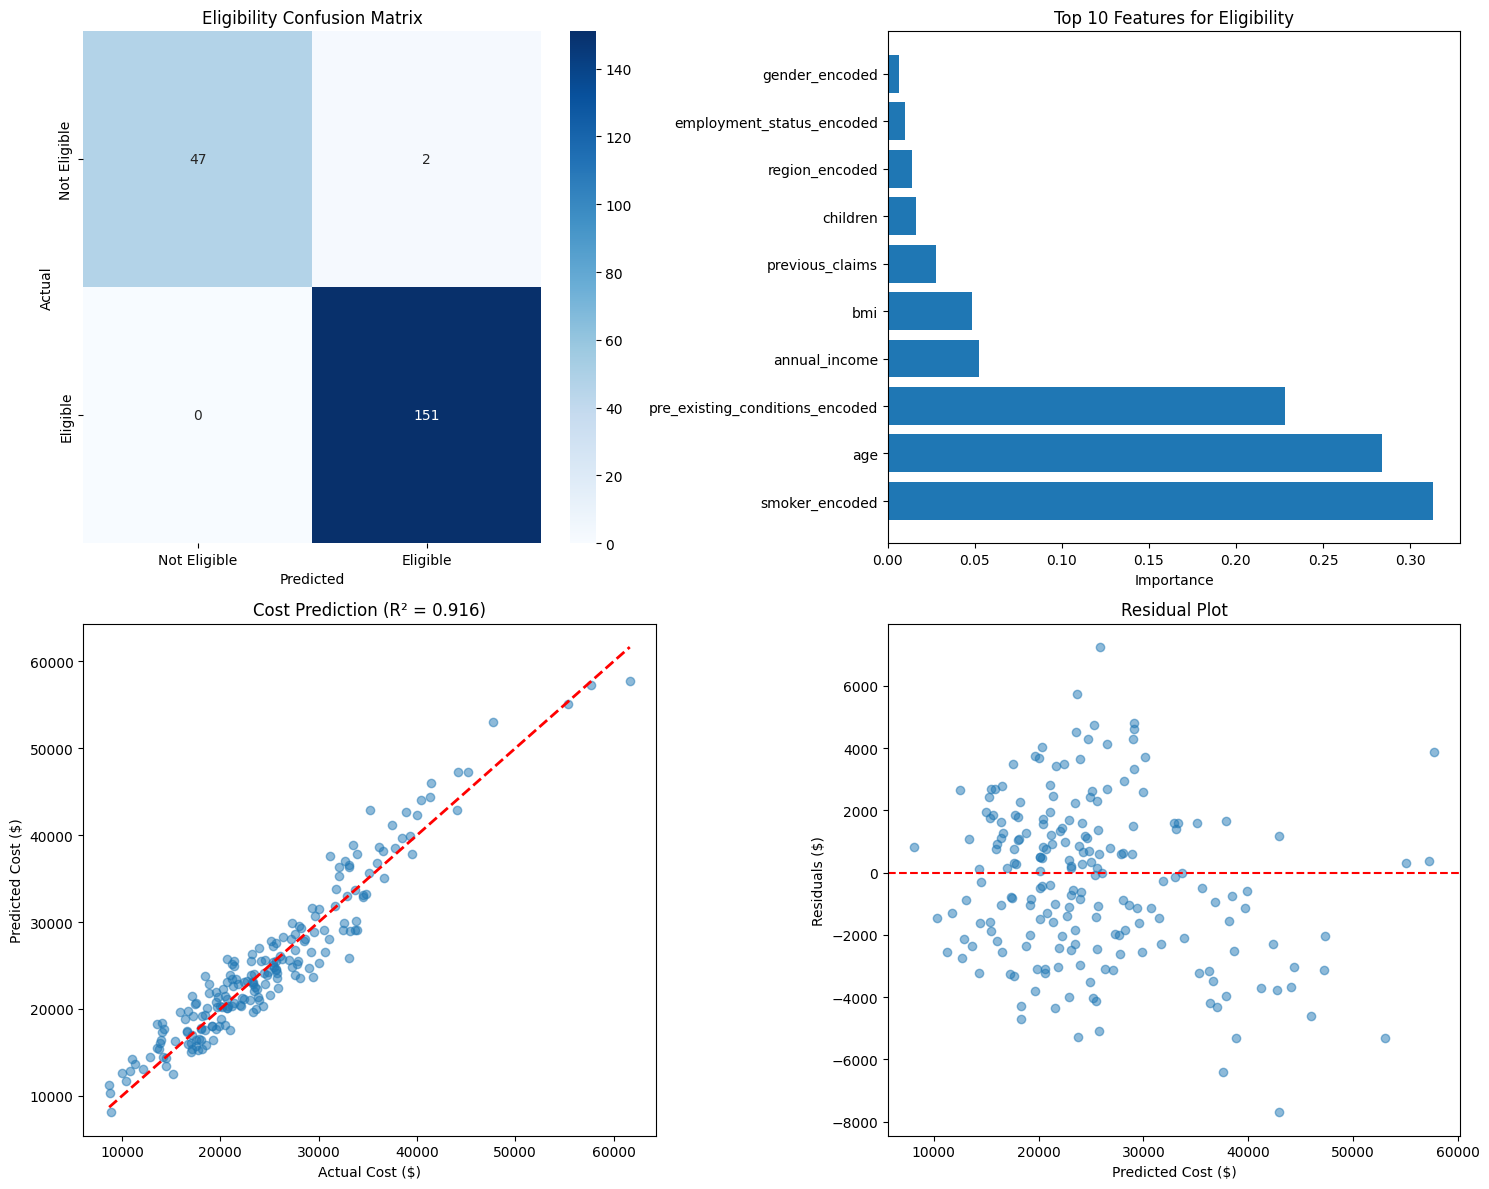


=== COMPLETE ===
Notebook execution finished successfully!
Models saved and ready for deployment.


In [11]:
# Cell 10: Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
cm = confusion_matrix(y_elig_test, y_elig_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Not Eligible', 'Eligible'],
            yticklabels=['Not Eligible', 'Eligible'])
axes[0, 0].set_title('Eligibility Confusion Matrix')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# Feature Importance (from RF base model)
rf_model = eligibility_model.estimators_[0]
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[0, 1].barh(feature_importance['feature'], feature_importance['importance'])
axes[0, 1].set_title('Top 10 Features for Eligibility')
axes[0, 1].set_xlabel('Importance')

# Predicted vs Actual Cost
axes[1, 0].scatter(y_cost_test, y_cost_pred, alpha=0.5)
axes[1, 0].plot([y_cost_test.min(), y_cost_test.max()], 
                [y_cost_test.min(), y_cost_test.max()], 
                'r--', lw=2)
axes[1, 0].set_xlabel('Actual Cost ($)')
axes[1, 0].set_ylabel('Predicted Cost ($)')
axes[1, 0].set_title(f'Cost Prediction (R² = {cost_r2:.3f})')

# Residual Plot
residuals = y_cost_test - y_cost_pred
axes[1, 1].scatter(y_cost_pred, residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Cost ($)')
axes[1, 1].set_ylabel('Residuals ($)')
axes[1, 1].set_title('Residual Plot')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== COMPLETE ===")
print("Notebook execution finished successfully!")
print("Models saved and ready for deployment.")